In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
from keras.models import Sequential

import matplotlib.pyplot as plt
from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import numpy as np

from tensorflow.keras.layers import BatchNormalization

import keras
from keras import *
from keras.layers import *
from pythainlp import word_tokenize
from pythainlp.word_vector import *
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder


from imblearn.over_sampling import SMOTE

from pythainlp import word_vector

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)

In [2]:
df = pd.read_csv('main_suicidal_data.csv').drop(columns='Unnamed: 0')

In [3]:
wModel = word_vector.WordVector(model_name="thai2fit_wv").get_model()
thai2dict = {}
for word in wModel.index_to_key:
    thai2dict[word] = wModel[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
thVocab = thai2vec.index.to_list()

In [4]:
ll = len(thai2vec)
for vidx in range(ll):
    if vidx % 100 == 0:
        print('\r' + str(vidx),end='')
    aa = thai2vec.iloc[[vidx]]
    ab = aa.values.tolist()
    if vidx == 0:
        vect = ab
    else:
        vect = np.vstack((vect,ab))

print("\n", vect.shape)

51300
 (51358, 300)


In [5]:
def tokenWord(wordTarget):
    wordToken = word_tokenize(wordTarget, engine='attacut')
    return wordToken

def convWord(cw):
    cWord = cw
    for ti in range(len(cWord)):
        if cWord[ti] == ' ':
            cWord[ti] = ''
        elif cWord[ti] not in thVocab:
            cWord[ti] = ''
    return cWord

def token2index(t2idx):
    w2index = []
    for wi in range(len(t2idx)):
        if t2idx[wi] in thVocab:
            w2index.append(thVocab.index(t2idx[wi]))
    return np.array(w2index)

def findMaxArray(fma):
    maxlen = 0
    for mi in range(len(fma)):
        nA = len(fma[mi])
        if nA > maxlen:
            maxlen = nA
    return maxlen

def fill0in(f0i):
    fMax = findMaxArray(f0i)
    for fi, ax in enumerate(f0i):
        if len(ax) < fMax:
            f0i[fi] = np.hstack((ax , np.zeros(fMax-len(ax))))
        f0i1 = np.array(f0i)
    return f0i1

def prepare2train(ipt):
    pre2t = []
    for pidx in range(len(ipt)):
        wp1 = ipt[pidx]
        pre2t.append(token2index(convWord(tokenWord(wp1))))
    return pre2t

In [6]:
df['Label_Enc'] = df['Label (Specialist)'].str.replace('Level 1','Low Level Depress')
df['Label_Enc'] = df['Label_Enc'].str.replace('Level 2','Mid Level Depress')
df['Label_Enc'] = df['Label_Enc'].str.replace('Level 3','Mid Level Depress')
df['Label_Enc'] = df['Label_Enc'].str.replace('Level 4','High Level Depress')
df['Label_Enc'] = df['Label_Enc'].str.replace('Level 5','High Level Depress')

conditions = [
    (df['Label_Enc'] == 'Other'),
    (df['Label_Enc'] == 'Low Level Depress'),
    (df['Label_Enc'] == 'Mid Level Depress'),
    (df['Label_Enc'] == 'High Level Depress'),
    ]

values = ['0', '1', '2', '3']

df['Label_Enc'] = np.select(conditions, values)


In [7]:
X = df['Tweet']
X_arr = X.to_list()
y = df['Label_Enc']

In [8]:
le = LabelEncoder()
le.fit(y)

LabelEncoder()

In [9]:
X = prepare2train(X_arr)
y = le.transform(y)

In [10]:
y = np.array(y)
X = fill0in(X)

In [11]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
    
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1)


# LSTM

In [30]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=51358,output_dim=300,name='embed'))

#Layer 2: LSTM layer
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(rate=0.5))

#Layer 5: Output layer
model.add(Dense(4, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, None, 300)         15407400  
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 15,493,038
Trainable params: 15,493,038
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam_opt,metrics=['accuracy'])

In [23]:
model.get_layer('embed').set_weights([vect])
model.get_layer('embed').trainable = True


In [24]:
history = model.fit(X_train,y_train,epochs=20,batch_size=32,callbacks=[early_stopping],validation_split=0.1)

Epoch 1/10


2023-01-30 13:43:45.286361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:43:45.711222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:43:45.728427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:43:46.073451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:43:46.101197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - ETA: 0s - loss: 1.5832 - accuracy: 0.2724

2023-01-30 13:44:03.376984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:44:03.532626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:44:03.545810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 21s 128ms/step - loss: 1.5832 - accuracy: 0.2724 - val_loss: 1.3954 - val_accuracy: 0.3730
Epoch 2/10
141/141 [==============================] - 16s 116ms/step - loss: 1.4056 - accuracy: 0.3478 - val_loss: 1.2932 - val_accuracy: 0.4240
Epoch 3/10
141/141 [==============================] - 15s 110ms/step - loss: 1.2944 - accuracy: 0.4046 - val_loss: 1.2088 - val_accuracy: 0.4540
Epoch 4/10
141/141 [==============================] - 16s 113ms/step - loss: 1.2268 - accuracy: 0.4325 - val_loss: 1.1666 - val_accuracy: 0.4740
Epoch 5/10
141/141 [==============================] - 16s 112ms/step - loss: 1.1804 - accuracy: 0.4512 - val_loss: 1.1456 - val_accuracy: 0.4670
Epoch 6/10
141/141 [==============================] - 17s 120ms/step - loss: 1.1416 - accuracy: 0.4717 - val_loss: 1.1275 - val_accuracy: 0.4930
Epoch 7/10
141/141 [==============================] - 16s 115ms/step - loss: 1.1146 - accuracy: 0.4872 - val_loss: 1.1143 - val_accuracy: 0.5

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


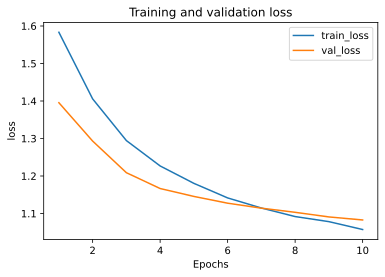

In [26]:
plot_metric(history, 'loss')

In [27]:
model_acc = model.evaluate(X_test,y_test)

35/35 [==============================] - 2s 47ms/step - loss: 1.0626 - accuracy: 0.5140


In [28]:
y_pred = np.argmax(model.predict(X_test),axis=1)

2023-01-30 13:46:34.795051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:46:35.039859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-30 13:46:35.063524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.47      0.44       285
           1       0.68      0.89      0.77       273
           2       0.45      0.38      0.41       277
           3       0.47      0.33      0.38       276

    accuracy                           0.51      1111
   macro avg       0.50      0.52      0.50      1111
weighted avg       0.50      0.51      0.50      1111

